# Capability Correlations

Let's start by importing all of the necessary libraries to conduct the analysis. 

In [1]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
from matplotlib.colors import ListedColormap
import operator
import math
from IPython.display import display, HTML
import collections

# please add your plotly api credentials to plotly_config in your own machine. Visit https://plot.ly/python/getting-started/
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

## Table of Contents

- [1. Patent and Publication differences on term pairs](#one)
    - [1.1. Axis building](#one-one)
    - [1.2. Function Design](#one-two)
    - [1.3. Patents and Publication Matrixes](#one-three)
    - [1.4. Analysing the differences](#one-four)
- [2. Patents and Publication Matrixes: Chronological Evolution](#two)
    - [2.1. Absolute Evolution](#two-one)
    - [2.2. Comparing the chronological evolution of asset types](#two-two)
        - [2.2.1. Feedstocks](#two-two-one)
        - [2.2.2. Outputs](#two-two-two)
- [3. Comparing the patenting and publication rates of individual terms](#three)
    - [3.1. Function design](#three-one)
    - [3.2. Feedstock](#three-two)
    - [3.3. Processing Technologies](#three-three)
    - [3.4. Output](#three-four)
    - [3.5. Comparison](#three-five)


## 1. Patent and Publication differences on term pairs <a class="anchor" id="one"></a>

In order to establish a base for understading the basis of the work, we wish to understand the occurence of severall feedstocks, processing technologies and outputs in our database. 

For example, how many assets (patents, papers, etc) contain the mix of processing technology X for output Y? 

To understand this in a more general way, the [AMICA](https://amica-pathfinder.net/) database will be transformed in an [co-occurence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix). This means, in the above described example that the number of assets that contain that mix will be an entry in a matrix, whyle the corresponfing technology and output will be columns/lines of the matrix. 

### 1.1. Axis building <a class="anchor" id="one-one"></a>

We start by creating, like previsouly a list of terms (feedstocks, processing technologies and outputs) so these become the axis of the capability matrix. 

In [2]:
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)


f_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
o_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:Output) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
pt_terms = list(set(DataFrame(connection_to_graph.data('MATCH (a:Asset)-[:CONTAINS]->(fs:ProcessingTech) RETURN  fs.term, count(a)')).as_matrix()[:, 1]))
bbo = list(set(f_terms + pt_terms + o_terms))
print len(bbo)
matrix_axis_names = bbo

352


Our matrix will have a total of 342 rows and 342 columns. 

### 1.2. Function Design <a class="anchor" id="one-two"></a>

We start by creating a function that given an asset (e.g."Patent", or "Publication"), returns a matrix where each entry correponds to the number of documents containing a certain term. For example: 

matrix[i, j] = z

norm_matrix[i, j] = w

There are z documents containing the term i and j.

Where:
norm_matrix[i,j] = (matrix[i, j] - mean(matrix)) / standard_deviation(matrix)

In [3]:
def get_asset_matrix(asset, normalization=True):
    
    # define queries
    asset_no_interestions = """     MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                    MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                    MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                    WHERE a.type = "{}"
                                    RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(asset)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    asset_intersections = """       MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                    WHERE fs<>t AND a.type = "{}"
                                    RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_no_intersections = DataFrame(connection_to_graph.data(asset_no_interestions)).as_matrix()
    
    # create matrix
    asset_matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])
    
    # for no intersections data
    for row in data_no_intersections:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [matrix_axis_names.index(element) for element in row[1::]]
        # add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            asset_matrix[pair[0], pair[1]] += frequency
            asset_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(asset_intersections.format(category, category, asset))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [matrix_axis_names.index(element) for element in row[1::]]
            # add frequency value to matrix position
            for pair in itertools.combinations(indexes, 2):
                asset_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                asset_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    #normalized_asset_matrix = (asset_matrix - np.mean(asset_matrix)) / np.std(asset_matrix)
    
    
    no_duplicates = np.triu(asset_matrix, 1)
    total_documents = np.sum(no_duplicates)
    normalized_asset_matrix = asset_matrix / total_documents
    
    # dynamic return 
    if normalization == True:
        return normalized_asset_matrix
    else: 
        return asset_matrix

### 1.3. Patents and Publication Matrixes <a class="anchor" id="one-three"></a>

We can now create the capability matrixes of publications and patents.

First, a query is created:

In [4]:
norm_mode = True
publication_matrix = get_asset_matrix('PUBLICATION', normalization=norm_mode)
patent_matrix = get_asset_matrix('PATENT', normalization=norm_mode)

Consequently, both matrixes are plotted. 

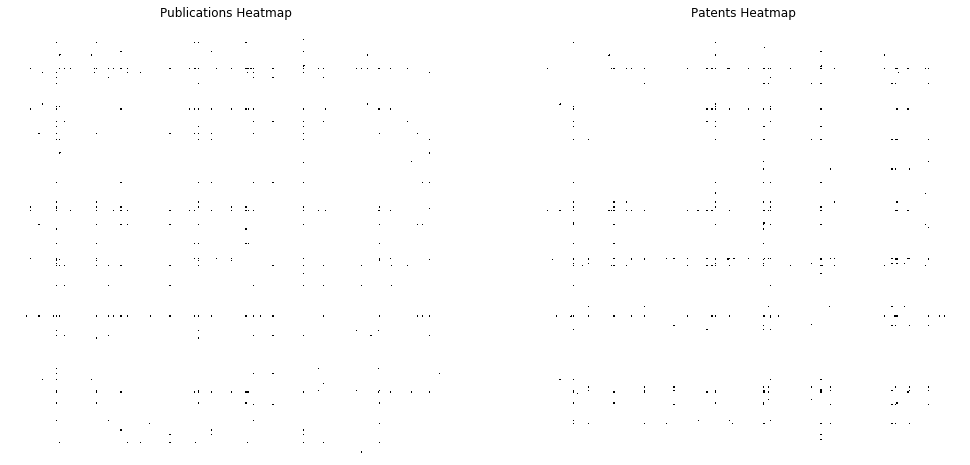

In [5]:
# create subplots
plt.subplots(2,1,figsize=(17,17))

bwhite = ListedColormap(['white', 'black'])
graph_holder = 0.001

plt.subplot(121)
sns.heatmap(publication_matrix,  cbar=None,cmap=bwhite, center=graph_holder, square=True, xticklabels=False, yticklabels=False)
plt.title('Publications Heatmap')

plt.subplot(122)
sns.heatmap(patent_matrix,  cbar=None,cmap=bwhite, center=graph_holder, square=True, xticklabels=False, yticklabels=False)
plt.title('Patents Heatmap')
plt.show()

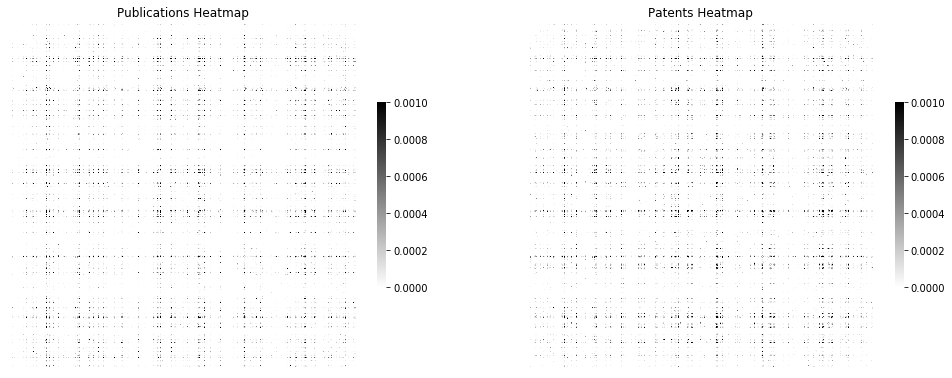

In [6]:
# create subplots
vmin = 0.0000
vmax = 0.001
bwhite = 'binary'


plt.subplots(2,1,figsize=(17,17))


plt.subplot(121)
sns.heatmap(publication_matrix,  cbar=True, cbar_kws={"shrink": .2}, cmap=bwhite, square=True, xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)
plt.title('Publications Heatmap')

plt.subplot(122)
sns.heatmap(patent_matrix,  cbar=True, cbar_kws={"shrink": .2}, cmap=bwhite, square=True, xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)
plt.title('Patents Heatmap')
plt.show()


Due to the scarcity of documents in certain intersepting categories, the matrixes are rather hard to read. 

We analyse some basic stats of these two matrixes..

In [7]:
print 'PATENTS:'
print 'Rows:', patent_matrix.shape[0]
print 'Columns:', patent_matrix.shape[1]
print 'Mean: ', np.mean(patent_matrix)
print 'Standart Deviation', np.std(patent_matrix)
print 'Max: ', np.amax(patent_matrix)
print 'Min: ', np.amin(patent_matrix)

PATENTS:
Rows: 352
Columns: 352
Mean:  1.6141528925619835e-05
Standart Deviation 0.00015838869428339098
Max:  0.021529758856947797
Min:  0.0


In [8]:
print 'PUBLICATIONS:'
print 'Rows:', publication_matrix.shape[0]
print 'Columns:', publication_matrix.shape[1]
print 'Mean: ', np.mean(publication_matrix)
print 'Standart Deviation', np.std(publication_matrix)
print 'Max: ', np.amax(publication_matrix)
print 'Min: ', np.amin(publication_matrix)

PUBLICATIONS:
Rows: 352
Columns: 352
Mean:  1.6141528925619835e-05
Standart Deviation 0.00018998027835549137
Max:  0.01888566726745553
Min:  0.0


Clearly, there are more publications, for instants, the average cell in the matrix has a value of 1.96, which compared to patents (0.7), is more than the double. 

Moreover, due to very high max values, (883, 2169) the matrixes are very irregular. 

### 1.4. Analysing the differences <a class="anchor" id="one-four"></a>

Now, we create a matrix where every entry correponds to the following:

difference[i,j] = patents[i,j] - publications[i,j].

This difference matrix, will give us a feel for what combination of terms are more patented Vs. researched or vice-versa.

We subtract the matrixes:

In [9]:
differences = patent_matrix - publication_matrix

And we plot the `diferences` matrix. 

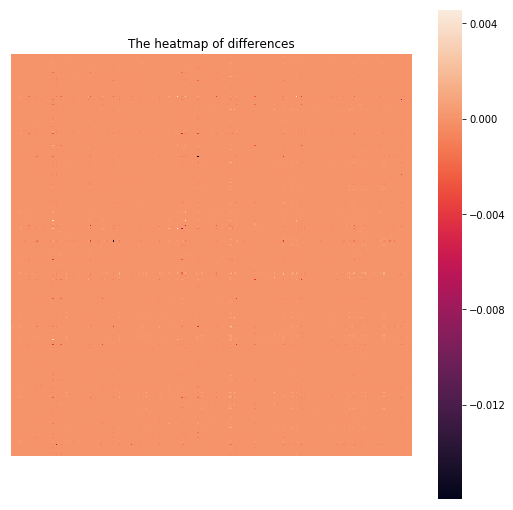

In [10]:
plt.subplots(1,1,figsize=(9,9))

plt.subplot(111)
sns.heatmap(differences, square=True, xticklabels=False, yticklabels=False)
plt.title('The heatmap of differences')
plt.show()

Due to the high volume of entries, it can be hard to visualize what is happening. 

Therefore, let's create a table with the combination of terms that are the most dicrepant. 

In [11]:
# list where all the values and indexes of matrix are stored
values = []
indexes = []
no_duplicates = np.abs(np.triu(differences, 1))

# loop through the matrix
for row_n in range(differences.shape[0]):
    for col_n in range(differences.shape[1]):
        values.append(no_duplicates[row_n, col_n])
        indexes.append((row_n, col_n))

Z = [indexes for _,indexes in sorted(zip(values,indexes))]

Let us create a dataframe of the most negative and positive relations for easy visualization. 

In [12]:
term_Dataframe = pd.DataFrame(
    {'First Term': [matrix_axis_names[e[0]] for e in Z],
     'Second Term': [matrix_axis_names[e[1]] for e in Z],
     'Patents': [patent_matrix[e[0], e[1]] for e in Z], 
     'Publications': [publication_matrix[e[0], e[1]] for e in Z], 
     'Difference': [no_duplicates[e[0], e[1]] for e in Z]
    })

term_Dataframe = term_Dataframe[['First Term', 'Second Term', 'Patents', 'Publications', 'Difference']]
term_Dataframe = term_Dataframe.sort_values('Difference', ascending=False).head(n=15)
print 'Absolute:'
display(HTML(term_Dataframe.to_html(index=False)))

Absolute:


First Term,Second Term,Patents,Publications,Difference
anaerobic digestion,biogas,0.000488,0.016448,0.015960
pyrolysis,bio-oil,0.000561,0.008202,0.007641
bioethanol,fermentation,0.002560,0.009282,0.006722
hydrolysis,bioethanol,0.001609,0.006748,0.005139
biodiesel,catalysis,0.000488,0.005337,0.004850
biogas,waste,0.001439,0.006182,0.004743
butanol,fermentation,0.006925,0.002377,0.004548
ethanol,catalysis,0.000317,0.004606,0.004289
ethanol,butanol,0.005364,0.001115,0.004250
ethanol,pressing,0.004828,0.000601,0.004227


In [13]:
total_patents = 4585
total_publications = 5313

patent_matrix = patent_matrix / total_patents
publication_matrix = publication_matrix / total_publications
differences = patent_matrix - publication_matrix

# list where all the values and indexes of matrix are stored
values = []
indexes = []
no_duplicates = np.abs(np.triu(differences, 1))

# loop through the matrix
for row_n in range(differences.shape[0]):
    for col_n in range(differences.shape[1]):
        values.append(no_duplicates[row_n, col_n])
        indexes.append((row_n, col_n))

Z = [indexes for _,indexes in sorted(zip(values,indexes))]


term_Dataframe = pd.DataFrame(
    {'First Term': [matrix_axis_names[e[0]] for e in Z],
     'Second Term': [matrix_axis_names[e[1]] for e in Z],
     'Patents': [patent_matrix[e[0], e[1]] for e in Z], 
     'Publications': [publication_matrix[e[0], e[1]] for e in Z], 
     'Difference': [no_duplicates[e[0], e[1]] for e in Z]
    })

term_Dataframe = term_Dataframe[['First Term', 'Second Term', 'Patents', 'Publications', 'Difference']]
term_Dataframe = term_Dataframe.sort_values('Difference', ascending=False).head(n=15)
print 'Absolute:'
display(HTML(term_Dataframe.to_html(index=False)))

Absolute:


First Term,Second Term,Patents,Publications,Difference
anaerobic digestion,biogas,1.063577e-07,3.095743e-06,2.989385e-06
pyrolysis,bio-oil,1.223114e-07,1.543775e-06,1.421463e-06
bioethanol,fermentation,5.583782e-07,1.746989e-06,1.188611e-06
ethanol,fermentation,4.695694e-06,3.554615e-06,1.141080e-06
butanol,fermentation,1.510280e-06,4.473996e-07,1.062880e-06
ethanol,butanol,1.169935e-06,2.097698e-07,9.601654e-07
ethanol,pressing,1.052942e-06,1.130790e-07,9.398626e-07
hydrolysis,bioethanol,3.509806e-07,1.270091e-06,9.191099e-07
biodiesel,catalysis,1.063577e-07,1.004601e-06,8.982429e-07
biogas,waste,3.137553e-07,1.163567e-06,8.498114e-07


## 2. Patents and Publication Matrixes: Chronological Evolution <a class="anchor" id="two"></a>

### 2.1. Absolute Evolution <a class="anchor" id="two-one"></a>

We start by creating a function that given a certain asset type and a timeline, returns the number of documents of that type for every year. 

In [14]:
def getTotalDocuments(assetType, startYear, endYear):
    assetQuery = """MATCH (a:Asset)
                    WHERE  a.type="{}"
                    AND toInteger(a.year)>={} AND toInteger(a.year)<={} 
                    AND NOT a.year = "Null"
                    RETURN  a.year, count(a)
                    ORDER BY a.year""".format(assetType, startYear, endYear)
    
    dataReturn = DataFrame(connection_to_graph.data(assetQuery)).as_matrix()
    timeLine = np.arange(startYear, endYear + 1)
    finalMatrix = np.transpose(np.vstack((timeLine, timeLine)))
    
    for i in range(finalMatrix.shape[0]):
        finalMatrix[i, 1] = 0
        for j in range(dataReturn.shape[0]):
            if finalMatrix[i, 0] == int(dataReturn[j, 0]):
                finalMatrix[i, 1] = dataReturn[j, 1]
                
    toReturn = {}
    
    toReturn['Years'] = finalMatrix[:, 0]
    toReturn['Quantity'] = finalMatrix[:, 1]
                
    return toReturn    

We now test the function

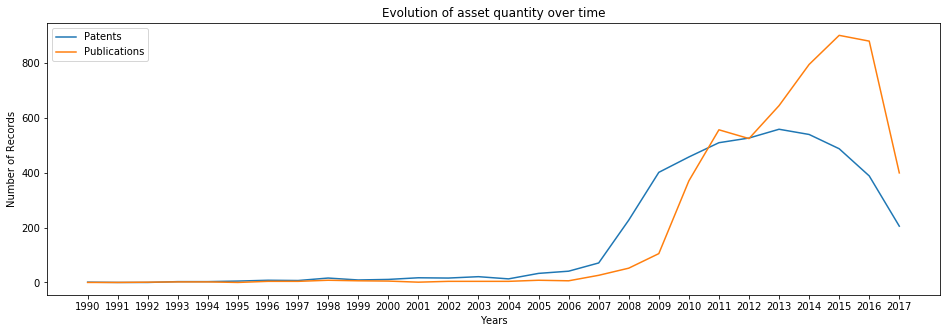

In [15]:
# define data 
startYear = 1990
endYear = 2017
patentTimeline = getTotalDocuments('PATENT', startYear, endYear)
publicationTimeline = getTotalDocuments('PUBLICATION', startYear, endYear)
title = 'Evolution of asset quantity over time'
x_label = 'Years'
y_label = 'Number of Records'

# plot evolution
plt.subplots(1,1,figsize=(16, 5))
plt.subplot(111)
plt.plot(patentTimeline['Years'], patentTimeline['Quantity'], label='Patents')
plt.plot(publicationTimeline['Years'], publicationTimeline['Quantity'], label='Publications')
plt.legend()
plt.xticks(publicationTimeline['Years'])
plt.title('Evolution of asset quantity over time')
plt.xlabel('Years') 
plt.ylabel('Number of Records') 
plt.show()

There is a clear relationship between the volume of patents and publications. Moreover, the number of patents seems to be inferior on average to the number of publications. 

However, there is a period where the number of patents is superior to the number of publications. Particularly the period between 2005 and 2011.

### 2.2. Comparing the chronological evolution of asset types <a class="anchor" id="two-two"></a>

A function that gives the chronological evolution of a certain asset. 

In [16]:
def getDocuments(processType, processTerm, assetType, startYear, endYear):
    assetQuery = """MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                    WHERE  fs.term = "{}" AND a.type="{}"
                    AND toInteger(a.year)>={} AND toInteger(a.year)<={} 
                    AND NOT a.year = "Null"
                    RETURN  a.year, count(a)
                    ORDER BY a.year""".format(processType, processTerm, assetType, startYear, endYear)
    
    assetTotalQuery = """   MATCH (a:Asset)
                            WHERE  a.type="{}"
                            AND toInteger(a.year)>={} AND toInteger(a.year)<={}
                            AND NOT a.year = "Null"
                            RETURN  a.year, count(a)
                            ORDER BY a.year""".format(assetType, startYear, endYear)
    
    dataReturn = DataFrame(connection_to_graph.data(assetQuery)).as_matrix()
    dataNormReturn = DataFrame(connection_to_graph.data(assetTotalQuery)).as_matrix()
     
    timeLine = np.arange(startYear, endYear + 1)
    finalMatrix = np.transpose(np.vstack((timeLine, timeLine, timeLine)))
    
    for i in range(finalMatrix.shape[0]):
        finalMatrix[i, 1] = 0
        finalMatrix[i, 2] = 0
        for j in range(dataReturn.shape[0]):
            if finalMatrix[i, 0] == int(dataReturn[j, 0]):
                finalMatrix[i, 1] = dataReturn[j, 1]
                
        for k in range(dataNormReturn.shape[0]):
            if finalMatrix[i, 0] == int(dataNormReturn[k, 0]):
                    finalMatrix[i, 2] = dataNormReturn[k, 1]
                
    toReturn = {}
    
    toReturn['Years'] = finalMatrix[:, 0]
    toReturn['Quantity'] = finalMatrix[:, 1]
    toReturn['NormQuantity'] = [finalMatrix[e, 1] / float(finalMatrix[e, 2])  if finalMatrix[e, 2] != 0 else 0 for e in range(finalMatrix.shape[0])]
                    
    return toReturn    

#### 2.2.1. Feedstocks <a class="anchor" id="two-two-one"></a>

We then test the function for severall different values of Feedstocks, in this case, the ones that are more proiminent in the database. 

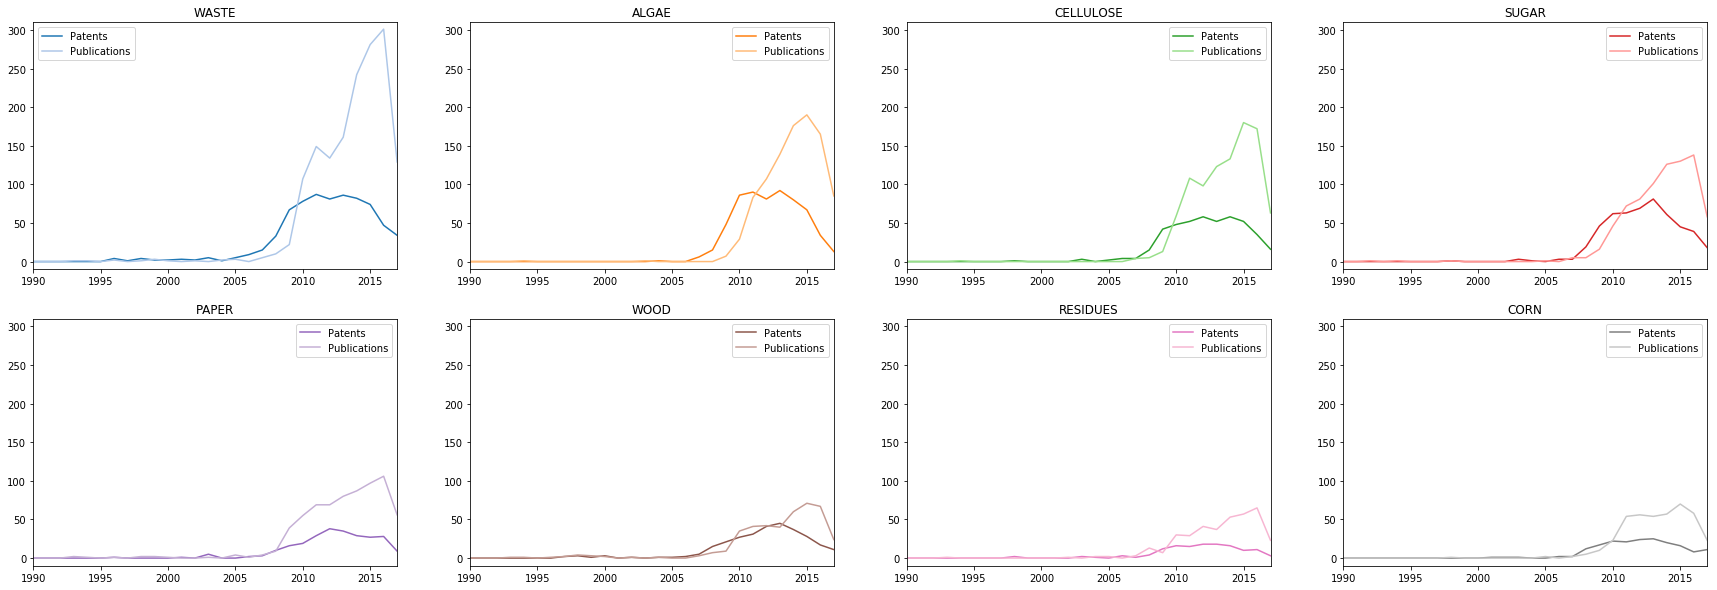

In [17]:
feedstockList = ['waste', 'algae', 'cellulose', 'sugar', 'paper', 'wood', 'residues', 'corn']

palette = plt.get_cmap('tab20')
plotCounter = 1
colorCounter = 0
plt.subplots(1,1,figsize=(30, 10))

for term in feedstockList:
    termPat = getDocuments('Feedstock', term, 'PATENT', 1990, 2017)
    termPub = getDocuments('Feedstock', term, 'PUBLICATION', 1990, 2017)
    plt.subplot(2,4, plotCounter)
    plt.plot(termPat['Years'], termPat['Quantity'], label = 'Patents', color = palette(colorCounter))
    plt.plot(termPub['Years'], termPub['Quantity'], label = 'Publications', color = palette(colorCounter + 1))
    plt.xlim(1990,2017)
    plt.ylim(-10,310)
    plt.title(term.upper())
    plt.legend()
    plotCounter += 1
    colorCounter += 2
    
plt.show()

It appears that the number of publications is on average, far superior to the number of patents. However, the behaviour of these assets appears to follow the behaviour of the general dataset.(e.g. Small period where patents are more important.)

#### 2.2.2. Outputs <a class="anchor" id="two-two-two"></a>

What about outputs as process variables? 

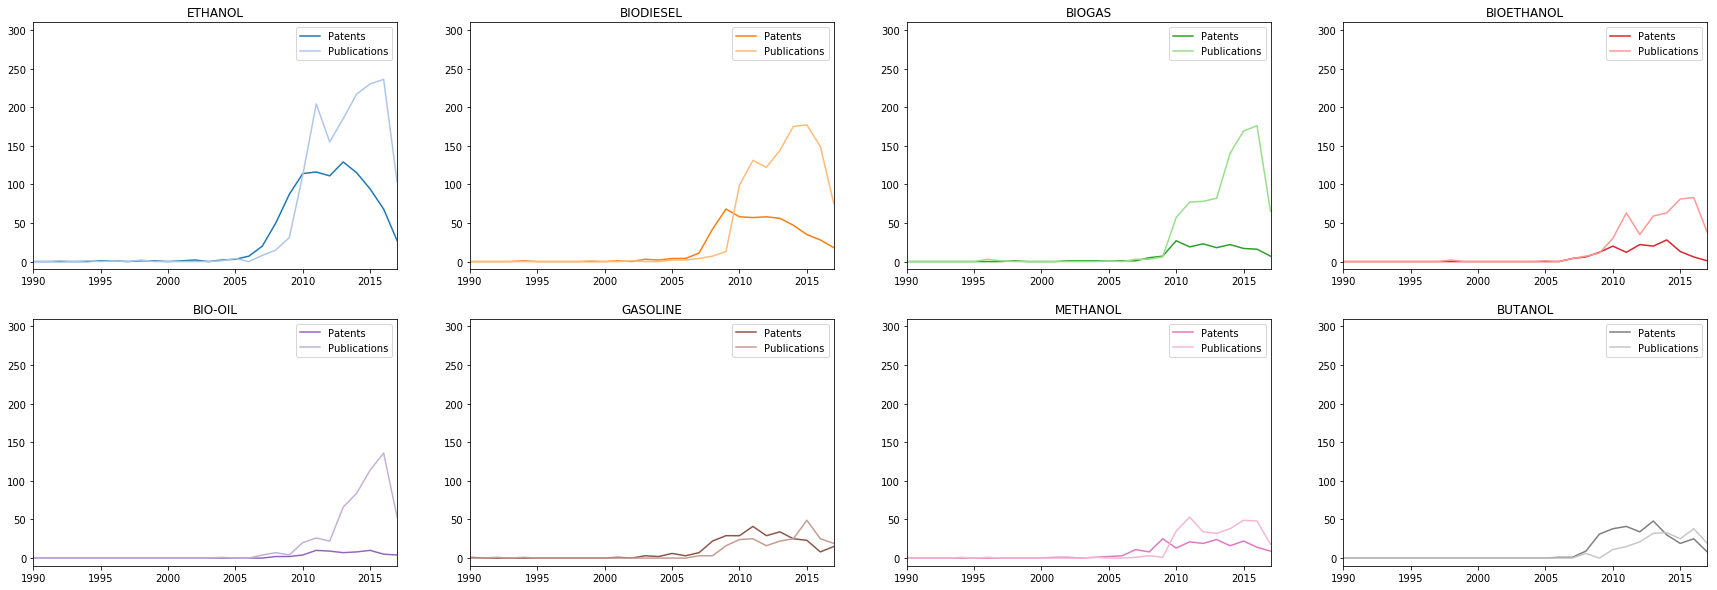

In [18]:
outputList = ["ethanol", "biodiesel", "biogas", "bioethanol", "bio-oil", "gasoline", "methanol", "butanol"]

palette = plt.get_cmap('tab20')
plotCounter = 1
colorCounter = 0
plt.subplots(1,1,figsize=(30, 10))

for term in outputList:
    termPat = getDocuments('Output', term, 'PATENT', 1990, 2017)
    termPub = getDocuments('Output', term, 'PUBLICATION', 1990, 2017)

    plt.subplot(2,4, plotCounter)
    plt.plot(termPat['Years'], termPat['Quantity'], label = 'Patents', color = palette(colorCounter))
    plt.plot(termPub['Years'], termPub['Quantity'] , label = 'Publications', color = palette(colorCounter + 1))
    plt.xlim(1990,2017)
    plt.ylim(-10,310)
    plt.title(term.upper())
    plt.legend()
    plotCounter += 1
    colorCounter += 2
    
plt.show()

The behaviour does not appear to differ greatly from the feedstocks. 

#### 2.2.3. Normalized Feedstocks <a class="anchor" id="two-two-one"></a>

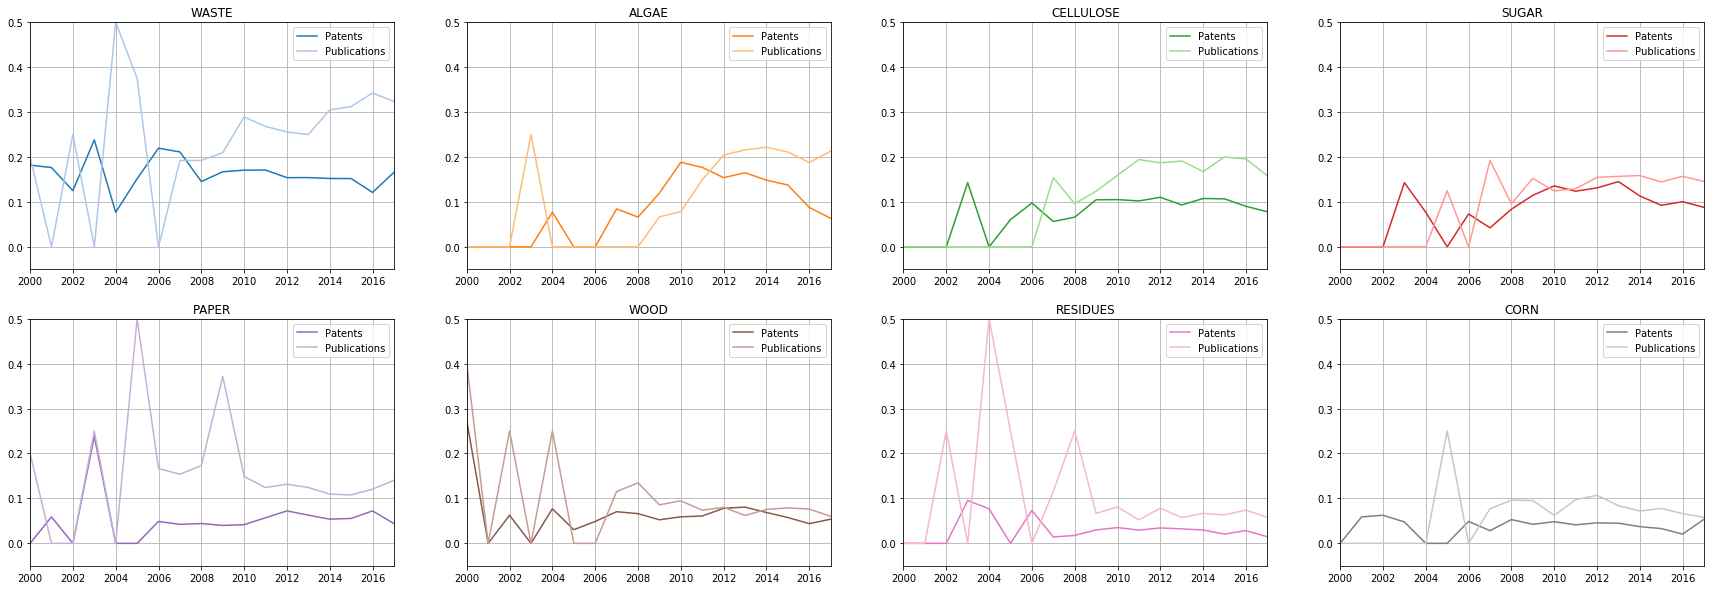

In [19]:
feedstockList = ['waste', 'algae', 'cellulose', 'sugar', 'paper', 'wood', 'residues', 'corn']


palette = plt.get_cmap('tab20')
plotCounter = 1
colorCounter = 0
plt.subplots(1,1,figsize=(30, 10))

for term in feedstockList:
    termPat = getDocuments('Feedstock', term, 'PATENT', 2000, 2017)
    termPub = getDocuments('Feedstock', term, 'PUBLICATION', 2000, 2017)
    plt.subplot(2,4, plotCounter)
    plt.plot(termPat['Years'], termPat['NormQuantity'], label = 'Patents', color = palette(colorCounter))
    plt.plot(termPub['Years'], termPub['NormQuantity'], label = 'Publications', color = palette(colorCounter + 1))
    plt.grid()
    plt.xlim(2000,2017)
    plt.ylim(-0.05,0.5)
    plt.title(term.upper())
    plt.legend()
    plotCounter += 1
    colorCounter += 2
    
plt.show()

## 3. Comparing the patenting and publication rates of individual terms <a class="anchor" id="three"></a>

### 3.1. Function design <a class="anchor" id="three-one"></a>

We create a function that given a certain process type (e.g. Output, ProcTech or Feedstock), returns the total assets in terms of patents and publications. 

In [20]:
def get_asset_distribution(processType):
    """
    This function takes a process type, say Feedstocks and returns the total assets in terms of Patents
    and Publications for that same asset. 
    """
    q = """ MATCH (a:Asset)-[:CONTAINS]->(fs:{})
            WHERE a.type="PATENT" OR a.type="PUBLICATION"
            RETURN  fs.term,a.type, count(a)
            ORDER BY fs.term""".format(processType)
    
    q_total = """   MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                    WHERE a.type="PATENT" OR a.type="PUBLICATION"
                    RETURN  a.type, count(a)""".format(processType)
    
    data = DataFrame(connection_to_graph.data(q)).as_matrix()
    patent_total = DataFrame(connection_to_graph.data(q_total)).as_matrix()[0, 1]
    publication_total = DataFrame(connection_to_graph.data(q_total)).as_matrix()[1, 1]

    terms = list(set(data[:, 2]))
    patents = []
    publications = []
    
    
    for term in terms: 
        publications.append(0)
        patents.append(0)
        for data_row in data: 
            if data_row[2] == term and data_row[0] == "PUBLICATION":
                publications = publications[:-1] + [data_row[1]]
            if data_row[2] == term and data_row[0] == "PATENT":
                patents = patents[:-1] + [data_row[1]]
                
    distribution = {}
    distribution['terms'] = terms
    distribution['publications'] = publications
    distribution['patents'] = patents
    distribution['publications_norm'] = [e / float(publication_total) for e in distribution['publications']]
    distribution['patents_norm'] = [e / float(patent_total) for e in distribution['patents']]

    return distribution

### 3.2. Feedstock <a class="anchor" id="three-two"></a>

We start by analysing Feedstock terms.

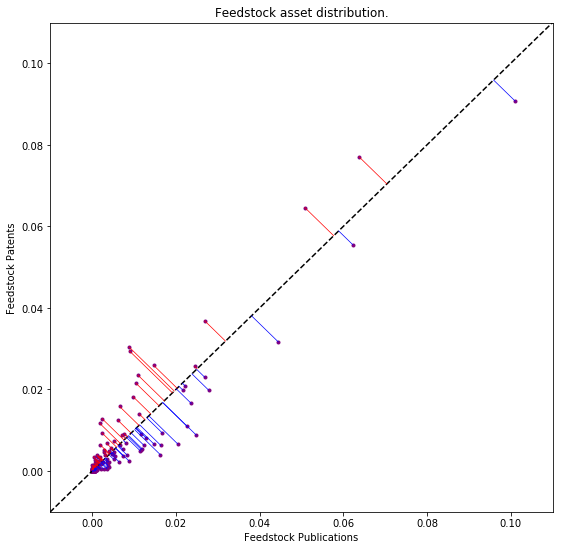

In [21]:
processType = 'Feedstock'
distribution = get_asset_distribution(processType)

def get_closest_in_line(i):
    x0 = distribution['publications_norm'][i]
    y0 = distribution['patents_norm'][i]
    m = 1
    k = 0
    x = (x0 + m * y0 - m * k)/((m ** 2) + 1)
    y = m * ((x0 + m * y0 - m*k)/((m**2) + 1)) + k
    return [x, y]


fig, ax1 = plt.subplots(figsize=(9,9))
plt.scatter(np.asarray(distribution['publications_norm']), np.asarray(distribution['patents_norm']), marker=".", color='purple')
plt.plot([-0.1, 0.11], [-0.1, 0.11], ls='--', color='black')
for index, term in enumerate(distribution['terms']):
    other_ = get_closest_in_line(index)
    if distribution['publications_norm'][index] < distribution['patents_norm'][index]:
        color = 'red'
    else: 
        color = 'blue'
        
    plt.plot([distribution['publications_norm'][index], other_[0]], [distribution['patents_norm'][index], other_[1]], color=color, lw=0.7)


plt.title('{} asset distribution.'.format(processType))
plt.xlabel('{} Publications'.format(processType))
plt.ylabel('{} Patents'.format(processType))
plt.xlim([-0.01, 0.11])
plt.ylim([-0.01, 0.11])
plt.show()

There appears to be a high positive correlation, the more patented a term is, the more researched it is. 

Every term has been normalized. 

**Outlier Detection**

We create a function that returns the outliers of a given list.

In [22]:
def distance_to_mean(i):
    x1 = distribution['publications_norm'][i]
    y1 = distribution['patents_norm'][i]
    x2 = get_closest_in_line(i)[0]
    y2 = get_closest_in_line(i)[1]
    
    distance = math.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
    return distance

def winner(i):
    x1 = distribution['publications_norm'][i]
    y1 = distribution['patents_norm'][i]
    if x1 > y1:
        return 'Publications'
    else:
        return 'Patents'
    
# create dataframe
term_Dataframe = pd.DataFrame(
    {'Name': distribution['terms'],
    'Patent Percentage': distribution['patents_norm'],
     'Publications Percentage': distribution['publications_norm'],
     'Distance to Mean': [distance_to_mean(i) for i in range(len(distribution['terms']))],
     'Bias':  [winner(i) for i in range(len(distribution['terms']))]
    })

# prepare dataframe
term_Dataframe = term_Dataframe[['Name', 'Patent Percentage','Publications Percentage', 'Distance to Mean', 'Bias']]
term_Dataframe = term_Dataframe.sort_values('Distance to Mean', ascending=False).head(n=10)
display(HTML(term_Dataframe.to_html(index=False)))

counter=collections.Counter([winner(i) for i in range(len(distribution['terms']))])

print 'In {} terms, {} appear more in patents and {} appear more in publications.'.format(len(distribution['terms']), counter['Patents'], counter['Publications'])

Name,Patent Percentage,Publications Percentage,Distance to Mean,Bias
starch,0.030417,0.008816,0.015274,Patents
grain,0.029412,0.008946,0.014472,Patents
agriculture,0.008798,0.024893,0.011381,Publications
sugar,0.064605,0.050823,0.009745,Patents
waste water,0.006662,0.020420,0.009729,Publications
algae,0.077049,0.063788,0.009376,Patents
paper,0.031674,0.044470,0.009048,Publications
blend,0.023504,0.010956,0.008873,Patents
energy crops,0.004022,0.016271,0.008661,Publications
sewage,0.010935,0.022689,0.008311,Publications


In 170 terms, 80 appear more in patents and 90 appear more in publications.


We then plot the above lists's boxplot. 

### 3.3. Processing Technologies <a class="anchor" id="three-three"></a>

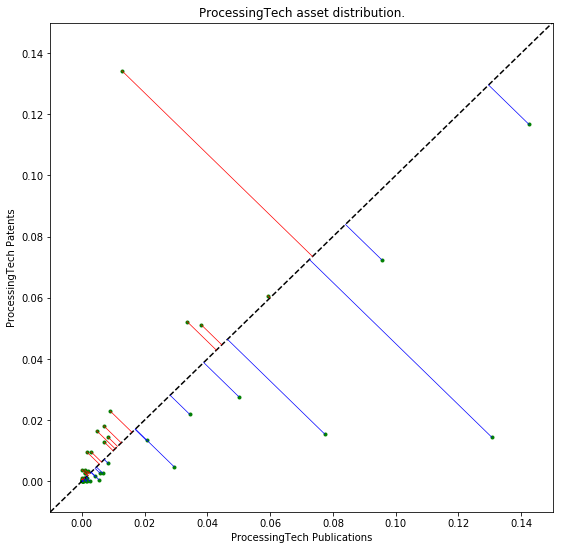

In [23]:
processType = 'ProcessingTech'
distribution = get_asset_distribution(processType)

fig, ax1 = plt.subplots(figsize=(9,9))
plt.scatter(np.asarray(distribution['publications_norm']), np.asarray(distribution['patents_norm']), marker=".", color='green')
plt.plot([-0.1, 0.15], [-0.1, 0.15], ls='--', color='black')
for index, term in enumerate(distribution['terms']):
    other_ = get_closest_in_line(index)
    if distribution['publications_norm'][index] < distribution['patents_norm'][index]:
        color = 'red'
    else: 
        color = 'blue'
        
    plt.plot([distribution['publications_norm'][index], other_[0]], [distribution['patents_norm'][index], other_[1]], color=color, lw=0.7)


plt.title('{} asset distribution.'.format(processType))
plt.xlabel('{} Publications'.format(processType))
plt.ylabel('{} Patents'.format(processType))
plt.xlim([-0.01, 0.15])
plt.ylim([-0.01, 0.15])
plt.show()

On average, processing technologies are more researched than patented. Which makes sense because they concern technologies and not processes.

**Outliers**

In [24]:
# create dataframe
term_Dataframe = pd.DataFrame(
    {'Name': distribution['terms'],
    'Patent Percentage': distribution['patents_norm'],
     'Publications Percentage': distribution['publications_norm'],
     'Distance to Mean': [distance_to_mean(i) for i in range(len(distribution['terms']))],
     'Bias':  [winner(i) for i in range(len(distribution['terms']))]
    })

# prepare dataframe
term_Dataframe = term_Dataframe[['Name', 'Patent Percentage','Publications Percentage', 'Distance to Mean', 'Bias']]
term_Dataframe = term_Dataframe.sort_values('Distance to Mean', ascending=False).head(n=10)
display(HTML(term_Dataframe.to_html(index=False)))

counter=collections.Counter([winner(i) for i in range(len(distribution['terms']))])

print 'In {} terms, {} appear more in patents and {} appear more in publications.'.format(len(distribution['terms']), counter['Patents'], counter['Publications'])

Name,Patent Percentage,Publications Percentage,Distance to Mean,Bias
pressing,0.134257,0.012747,0.085921,Patents
anaerobic digestion,0.014385,0.130609,0.082183,Publications
fermentation,0.274907,0.188580,0.061042,Patents
catalysis,0.015450,0.077353,0.043772,Publications
hydrolysis,0.116676,0.142483,0.018249,Publications
fast pyrolysis,0.004795,0.029335,0.017352,Publications
pyrolysis,0.072456,0.095512,0.016303,Publications
enzymatic hydrolysis,0.027704,0.049939,0.015723,Publications
gasification,0.052211,0.033525,0.013213,Patents
pyrolysis oil,0.022909,0.009080,0.009779,Patents


In 48 terms, 25 appear more in patents and 23 appear more in publications.


### 3.4. Output <a class="anchor" id="three-four"></a>

We take a look at the outputs. 

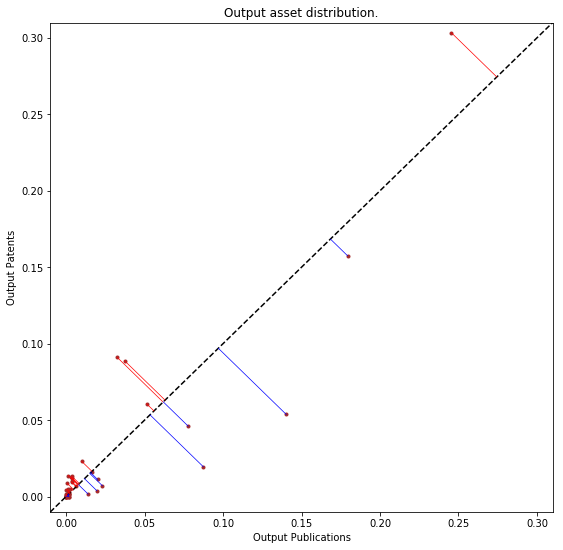

In [25]:
processType = 'Output'
distribution = get_asset_distribution(processType)

fig, ax1 = plt.subplots(figsize=(9,9))
plt.scatter(np.asarray(distribution['publications_norm']), np.asarray(distribution['patents_norm']), marker=".", color='brown')
plt.plot([-0.1, 0.32], [-0.1, 0.32], ls='--', color='black')
for index, term in enumerate(distribution['terms']):
    other_ = get_closest_in_line(index)
    if distribution['publications_norm'][index] < distribution['patents_norm'][index]:
        color = 'red'
        label = 'Patent Bias'
    else: 
        color = 'blue'
        label = 'Publication Bias'
        
    plt.plot([distribution['publications_norm'][index], other_[0]], [distribution['patents_norm'][index], other_[1]], color=color, lw=0.7, label=label)


plt.title('{} asset distribution.'.format(processType))
plt.xlabel('{} Publications'.format(processType))
plt.ylabel('{} Patents'.format(processType))
plt.xlim([-0.01, 0.31])
plt.ylim([-0.01, 0.31])
plt.show()

Outputs appear to have the same behaviour as processing technologies, a higher tendency to be published rather than patented. 

**Outliers**

In [26]:
# create dataframe
term_Dataframe = pd.DataFrame(
    {'Name': distribution['terms'],
    'Patent Percentage': distribution['patents_norm'],
     'Publications Percentage': distribution['publications_norm'],
     'Distance to Mean': [distance_to_mean(i) for i in range(len(distribution['terms']))],
     'Bias':  [winner(i) for i in range(len(distribution['terms']))]
    })

# prepare dataframe
term_Dataframe = term_Dataframe[['Name', 'Patent Percentage','Publications Percentage', 'Distance to Mean', 'Bias']]
term_Dataframe = term_Dataframe.sort_values('Distance to Mean', ascending=False).head(n=10)
display(HTML(term_Dataframe.to_html(index=False)))

counter=collections.Counter([winner(i) for i in range(len(distribution['terms']))])

print 'In {} terms, {} appear more in patents and {} appear more in publications.'.format(len(distribution['terms']), counter['Patents'], counter['Publications'])

Name,Patent Percentage,Publications Percentage,Distance to Mean,Bias
biogas,0.053657,0.140277,0.061249,Publications
bio-oil,0.019483,0.087388,0.048016,Publications
butanol,0.091025,0.032547,0.041351,Patents
ethanol,0.303417,0.245403,0.041023,Patents
gasoline,0.088790,0.037266,0.036433,Patents
bioethanol,0.045992,0.077787,0.022483,Publications
biodiesel,0.157458,0.179333,0.015468,Publications
cellulosic ethanol,0.007027,0.023108,0.011371,Publications
cellulosic biofuel,0.003833,0.019528,0.011098,Publications
pellets,0.022996,0.009927,0.009241,Patents


In 45 terms, 25 appear more in patents and 20 appear more in publications.


### 3.5. Comparison <a class="anchor" id="three-five"></a>

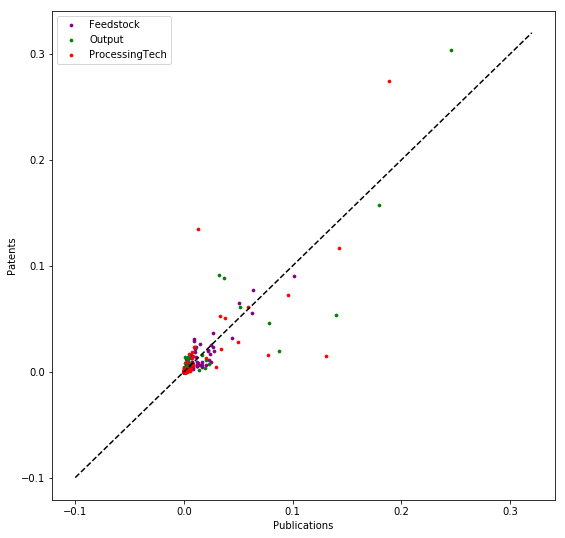

In [27]:
processTypes = ['Feedstock', 'Output', 'ProcessingTech']
colors = ['purple', 'green', 'red']


fig, ax1 = plt.subplots(figsize=(9,9))
for master_idx, process in enumerate(processTypes):
    distribution = get_asset_distribution(process)
    
    plt.scatter(distribution['publications_norm'], distribution['patents_norm'], color=colors[master_idx], lw=0.7, marker='.', label=process)

    
plt.plot([-0.1, 0.32], [-0.1, 0.32], ls='--', color='black')
plt.legend()
plt.xlabel('Publications')
plt.ylabel('Patents')
plt.show()